In [17]:
from scqbf import *
from scqbf.solvers import *

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from concurrent.futures import ProcessPoolExecutor, as_completed

In [18]:
max_value: float = 14472.64 # Valor max encontrado para a instancia 1.2
instance = ScQbfInstance.from_file("instances/gen2/instance2.txt")
instance_target_pairs = [
    (instance, 0.5*max_value),
    (instance, 0.75*max_value),
    (instance, 0.9*max_value),
]

In [19]:
# Base serial version (unused)

# def process_pair(instance_target_pair: list[ScQbfInstance, float]):
#     instance, target = instance_target_pair
    
#     tc = TerminationCriteria(max_time=10*60, max_value=target)
#     heuristics: list[SCQBF_Solver] = [
#         ScQbfGrasp(instance, termination_criteria=tc),
#         ScQbfTS(instance, termination_criteria=tc),
#         ScQbfGA(instance, termination_criteria=tc),
#     ]
    
#     results = {}
#     for heuristic in heuristics:
#         heuristic_results = []
#         for i in range(50):
#             random.seed(i)
#             heuristic.solve()
#             heuristic_results.append({
#                 'time': heuristic.execution_time,
#                 'objfun_val': heuristic.best_solution.objfun_val
#             })
#         results[heuristic.__class__.__name__] = heuristic_results
#     return (instance, target, results)


In [20]:
from aux import process_single_run

# def process_single_run(args):
#     """Helper function to process a single run of a heuristic"""
#     heuristic_class, instance, tc, seed = args
#     random.seed(seed)
#     heuristic = heuristic_class(instance, termination_criteria=tc)
#     heuristic.solve()
#     return {
#         'time': heuristic.execution_time,
#         'objfun_val': heuristic.best_solution.objfun_val
#     }

def process_pair(instance_target_pair: list[ScQbfInstance, float]):
    instance, target = instance_target_pair
    
    pickle_dir = Path("pickles/tttplots")
    pickle_dir.mkdir(parents=True, exist_ok=True)
    
    # unique id for this instance-target pair
    instance_name = "2.2"
    pair_id = f"{instance_name}_target_{target:.2f}"
    
    tc = TerminationCriteria(max_time_secs=10*60, target_value=target)
    heuristic_classes = [ScQbfGrasp, ScQbfTS, ScQbfGA]
    
    results = {}
    for heuristic_class in heuristic_classes:
        heuristic_name = heuristic_class.__name__
        pickle_file = pickle_dir / f"{pair_id}_{heuristic_name}.pkl"
        
        if pickle_file.exists():
            with open(pickle_file, 'rb') as f:
                results[heuristic_name] = pickle.load(f)
            print(f"Loaded existing results for {heuristic_name} on {pair_id}")
            continue
        
        # parallelism
        print(f"Processing {heuristic_name} on {pair_id} (50 runs in parallel)")
        run_args = [(heuristic_class, instance, tc, i) for i in range(50)]
        with ProcessPoolExecutor(max_workers=6) as executor:
            heuristic_results = list(executor.map(process_single_run, run_args))
        
        # pickle
        results[heuristic_name] = heuristic_results
        with open(pickle_file, 'wb') as f:
            pickle.dump(heuristic_results, f)
        print(f"Saved results for {heuristic_name} on {pair_id}")
    
    return results

In [21]:
# To pickle later
pickle_dir = Path("pickles/tttplots/pair_results")
pickle_dir.mkdir(parents=True, exist_ok=True)

all_results = {}

for instance, target in instance_target_pairs:
    instance_name = "2.2"
    pair_id = f"{instance_name}_target_{target:.2f}"

    pair_pickle = pickle_dir / f"{pair_id}_complete.pkl"
    
    if pair_pickle.exists():
        with open(pair_pickle, 'rb') as f:
            pair_results = pickle.load(f)
        print(f"Loaded complete results for {pair_id}")
    else:
        pair_results = process_pair((instance, target))
        
        with open(pair_pickle, 'wb') as f:
            pickle.dump(pair_results, f)
        print(f"Saved complete results for {pair_id}")
    
    all_results[pair_id] = pair_results

Processing ScQbfGrasp on 2.2_target_7236.32 (50 runs in parallel)
Saved results for ScQbfGrasp on 2.2_target_7236.32
Processing ScQbfTS on 2.2_target_7236.32 (50 runs in parallel)
Saved results for ScQbfTS on 2.2_target_7236.32
Processing ScQbfGA on 2.2_target_7236.32 (50 runs in parallel)
Saved results for ScQbfGA on 2.2_target_7236.32
Saved complete results for 2.2_target_7236.32
Processing ScQbfGrasp on 2.2_target_10854.48 (50 runs in parallel)
Saved results for ScQbfGrasp on 2.2_target_10854.48
Processing ScQbfTS on 2.2_target_10854.48 (50 runs in parallel)
Saved results for ScQbfTS on 2.2_target_10854.48
Processing ScQbfGA on 2.2_target_10854.48 (50 runs in parallel)
Saved results for ScQbfGA on 2.2_target_10854.48
Saved complete results for 2.2_target_10854.48
Processing ScQbfGrasp on 2.2_target_13025.38 (50 runs in parallel)
Saved results for ScQbfGrasp on 2.2_target_13025.38
Processing ScQbfTS on 2.2_target_13025.38 (50 runs in parallel)
Saved results for ScQbfTS on 2.2_target_

In [22]:
# Load all pickled pair results and create dataframes
pickle_dir = Path("pickles/tttplots/pair_results")

dataframes = {}
for pair_id, pair_results in all_results.items():
    rows = []
    
    for heuristic_name, heuristic_results in pair_results.items():
        for run_idx, result in enumerate(heuristic_results):
            rows.append({
                'heuristic': heuristic_name,
                # 'run': run_idx,
                'time': result['time'],
                'objfun_val': result['objfun_val']
            })
    
    df = pd.DataFrame(rows)
    dataframes[pair_id] = df
    print(f"Created dataframe for {pair_id}: {len(df)} rows")

Created dataframe for 2.2_target_7236.32: 150 rows
Created dataframe for 2.2_target_10854.48: 150 rows
Created dataframe for 2.2_target_13025.38: 150 rows


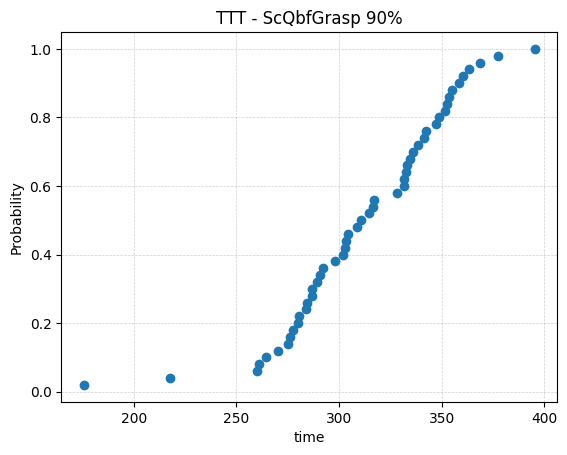

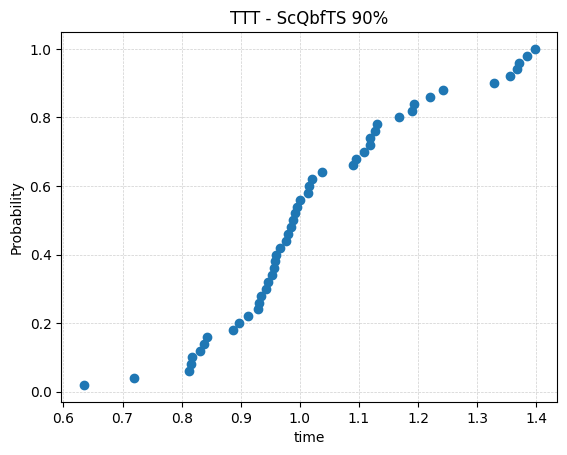

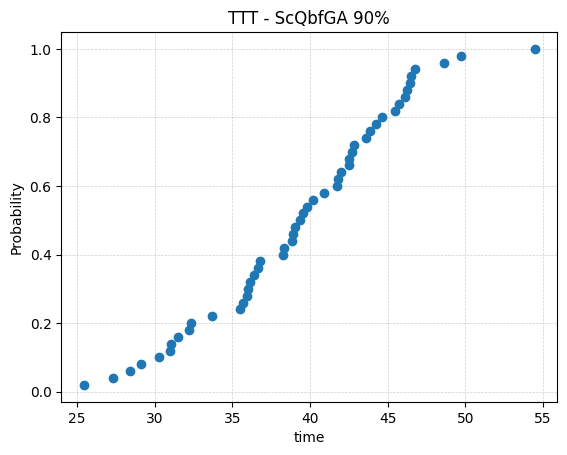

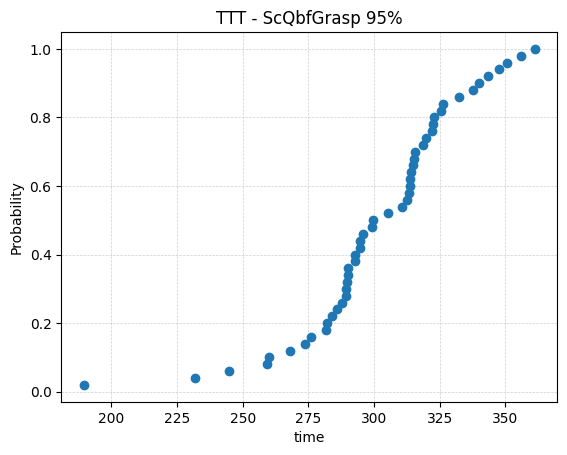

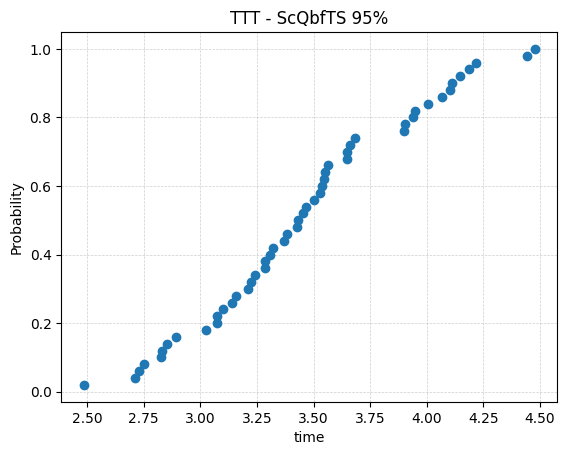

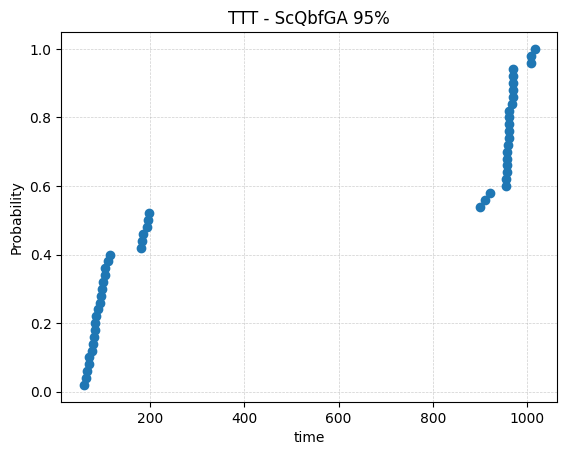

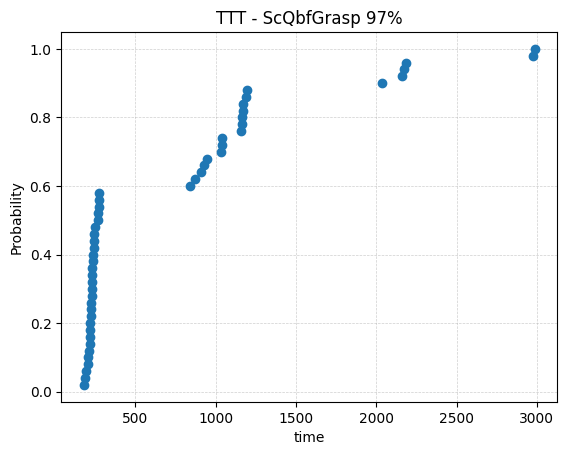

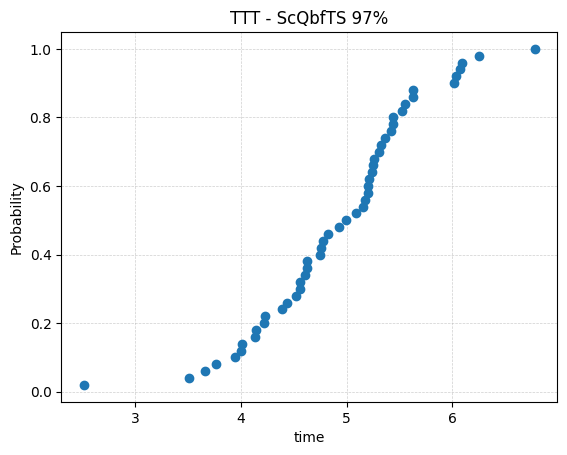

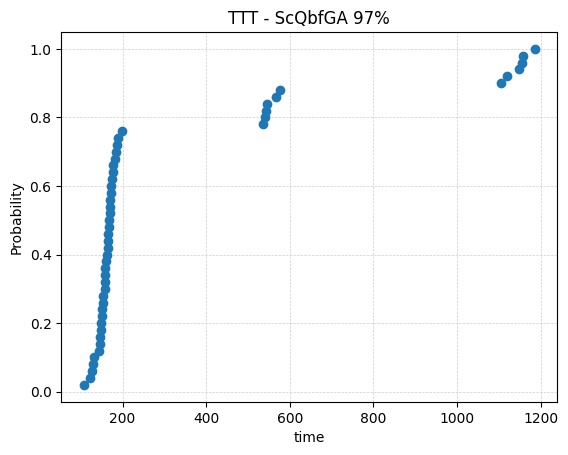

In [24]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

heuristics = ["ScQbfGrasp", "ScQbfTS", "ScQbfGA"]

def split_by_heuristic(df, heur_col="heuristic", time_col="time (s)"):
    return {h: df[df[heur_col] == h].dropna(subset=[time_col]) for h in heuristics}

def ttt_plot(df, time_col="time", title=None):
    x = np.sort(df[time_col])
    y = np.arange(1, len(x)+1) / len(x)
    plt.plot(x, y, "o")
    plt.xlabel(time_col); plt.ylabel("Probability")
    if title: plt.title(title)
    plt.grid(True, ls="--", lw=0.5, alpha=0.6)
    plt.show()
    return x, y

def plot_all(df, percentile, heur_col="heuristic", time_col="time"):
    parts = split_by_heuristic(df, heur_col, time_col)
    return {h: ttt_plot(parts[h], time_col, f"TTT - {h} {percentile}%") for h in heuristics}

results = plot_all(dataframes['2.2_target_7236.32'], 90)
results = plot_all(dataframes['2.2_target_10854.48'], 95)
results = plot_all(dataframes['2.2_target_13025.38'], 97)
# dataframes